In [1]:
import segmentation_models_pytorch as smp
import vaex as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from scripts.config import Config
from scripts.utils import (CellDataset, 
                           im_convert, 
                           display_dataset,
                           get_img_paths)

from scripts.train import train
# %matplotlib inline

config = Config()
sns.set() 

In [2]:
df_train = pd.read_csv(config.TRAIN_CSV)

In [3]:
df_train.head()

#,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,'118145 6 118849 7 119553 8 120257 8 120961 9 12...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,'189036 1 189739 3 190441 6 191144 7 191848 8 19...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,'173567 3 174270 5 174974 5 175678 6 176382 7 17...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,'196723 4 197427 6 198130 7 198834 8 199538 8 20...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,'167818 3 168522 5 169225 7 169928 8 170632 9 17...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
5,0030fd0e6378,'205984 2 206687 4 207391 5 208095 5 208799 6 20...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
6,0030fd0e6378,'203101 2 203805 5 204509 7 205213 10 205917 12 ...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
7,0030fd0e6378,'191900 2 192604 3 193308 4 194012 5 194717 5 19...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
8,0030fd0e6378,'184848 3 185551 5 186254 7 186958 8 187662 9 18...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
9,0030fd0e6378,'165119 1 165822 4 166526 6 167230 9 167935 9 16...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [4]:
df_train.info()

In [5]:
train_images_path = get_img_paths(config.TRAIN_PATH)

100%|██████████| 606/606 [00:00<00:00, 204107.30it/s]


In [6]:
gb = df_train.groupby('id')
image_ids = list(df_train.id.unique())

image_id = image_ids[0]
df = gb.get_group(image_id)
image_id
# labels = df_train[df_train["id"] == image_id]["annotation"].tolist()

'303e22f9ccd3'

In [7]:
vc = df_train["cell_type"].value_counts()

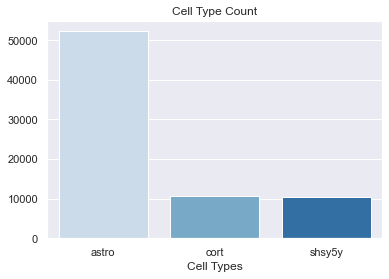

In [8]:
sns.barplot(x=df_train["cell_type"].unique(), y=vc, palette="Blues")
plt.title("Cell Type Count")
plt.xlabel("Cell Types")
plt.show()

In [9]:
ds_train = CellDataset(df_train)

['data\\train\\303e22f9ccd3.png', 'data\\train\\4425efbbacfc.png', 'data\\train\\b861811eaff6.png', 'data\\train\\8d0f8970d171.png', 'data\\train\\c25db38e918e.png', 'data\\train\\1d618b80769f.png', 'data\\train\\1ea4e44e5497.png', 'data\\train\\21b1ae35bd39.png', 'data\\train\\2e8a61b4f6b5.png', 'data\\train\\315b21b955c6.png', 'data\\train\\5d57448ab949.png', 'data\\train\\ca167f336091.png', 'data\\train\\d14e4fe1fef1.png', 'data\\train\\7f21996da2e6.png', 'data\\train\\8050704a02eb.png', 'data\\train\\88203fd2557d.png', 'data\\train\\ea362f1a9844.png', 'data\\train\\ef866d97431e.png', 'data\\train\\f7343d843bbd.png', 'data\\train\\9cfd6ebebc94.png', 'data\\train\\a55cec7ee7a1.png', 'data\\train\\042c17cd9143.png', 'data\\train\\16e538bbe8c5.png', 'data\\train\\478a2c53f075.png', 'data\\train\\795651f7b04a.png', 'data\\train\\f6abc09eb12f.png', 'data\\train\\9e2bc2d20e43.png', 'data\\train\\07e9ba109e34.png', 'data\\train\\085eb8fec206.png', 'data\\train\\89dceefff181.png', 'data\\tr

ValueError: ['data\\train\\303e22f9ccd3.png', 'data\\train\\4425efbbacfc.png', 'data\\train\\b861811eaff6.png', 'data\\train\\8d0f8970d171.png', 'data\\train\\c25db38e918e.png', 'data\\train\\1d618b80769f.png', 'data\\train\\1ea4e44e5497.png', 'data\\train\\21b1ae35bd39.png', 'data\\train\\2e8a61b4f6b5.png', 'data\\train\\315b21b955c6.png', 'data\\train\\5d57448ab949.png', 'data\\train\\ca167f336091.png', 'data\\train\\d14e4fe1fef1.png', 'data\\train\\7f21996da2e6.png', 'data\\train\\8050704a02eb.png', 'data\\train\\88203fd2557d.png', 'data\\train\\ea362f1a9844.png', 'data\\train\\ef866d97431e.png', 'data\\train\\f7343d843bbd.png', 'data\\train\\9cfd6ebebc94.png', 'data\\train\\a55cec7ee7a1.png', 'data\\train\\042c17cd9143.png', 'data\\train\\16e538bbe8c5.png', 'data\\train\\478a2c53f075.png', 'data\\train\\795651f7b04a.png', 'data\\train\\f6abc09eb12f.png', 'data\\train\\9e2bc2d20e43.png', 'data\\train\\07e9ba109e34.png', 'data\\train\\085eb8fec206.png', 'data\\train\\89dceefff181.png', 'data\\train\\8e7199072220.png', 'data\\train\\90a3e24b62b0.png', 'data\\train\\e1e10dd96535.png', 'data\\train\\22e0c43da285.png', 'data\\train\\499a225c835d.png', 'data\\train\\4b21aa9b6c84.png', 'data\\train\\adbaf2416db2.png', 'data\\train\\98fd9ed43654.png', 'data\\train\\e29015d36459.png', 'data\\train\\c1a8710f13a5.png', 'data\\train\\0c5938ac5e3c.png', 'data\\train\\418853314d5b.png', 'data\\train\\41c57fe26957.png', 'data\\train\\7b67cd233fcd.png', 'data\\train\\e8ae919aa92e.png', 'data\\train\\0ba181d412da.png', 'data\\train\\29dfe87f3a44.png', 'data\\train\\c8522b0f2063.png', 'data\\train\\2384e7378d16.png', 'data\\train\\29efe1120825.png', 'data\\train\\3f29e529f210.png', 'data\\train\\7570dd2d34bb.png', 'data\\train\\e92c56871769.png', 'data\\train\\9d23373b7bf8.png', 'data\\train\\04cd81dfb245.png', 'data\\train\\41a1f09b4f4e.png', 'data\\train\\6955df3e6c27.png', 'data\\train\\4cef27c8f779.png', 'data\\train\\5d066f4c3eef.png', 'data\\train\\25fd50629a5c.png', 'data\\train\\4c98ec6b42aa.png', 'data\\train\\5bbf4c20aad2.png', 'data\\train\\8f276651b26c.png', 'data\\train\\f76d1d2d5405.png', 'data\\train\\a162768bcf04.png', 'data\\train\\af47d104aa7e.png', 'data\\train\\ee6d4d0a17b6.png', 'data\\train\\fbb4fbe7100d.png', 'data\\train\\6f90a53cf326.png', 'data\\train\\8501cf5525d4.png', 'data\\train\\17754cb5b287.png', 'data\\train\\52a2e248d75b.png', 'data\\train\\5e9130834984.png', 'data\\train\\78440cb4b47d.png', 'data\\train\\b9056ac30b4b.png', 'data\\train\\bc0b9c1ff4dc.png', 'data\\train\\a28407ce196e.png', 'data\\train\\1d2396667910.png', 'data\\train\\6b6f2ee6467a.png', 'data\\train\\559904fcd4a2.png', 'data\\train\\d3d272e75cdb.png', 'data\\train\\ad12c1357f63.png', 'data\\train\\aff8fb4fc364.png', 'data\\train\\b208a1b645a1.png', 'data\\train\\d8fc6dd956f8.png', 'data\\train\\c67dd29ad915.png', 'data\\train\\1242e4ec6ef3.png', 'data\\train\\71d6e508abdc.png', 'data\\train\\724097951299.png', 'data\\train\\74a506f1d7e8.png', 'data\\train\\5507c81bdcb6.png', 'data\\train\\b0a5b4340364.png', 'data\\train\\856cbd30d034.png', 'data\\train\\8b6d3ad0fb2d.png', 'data\\train\\8f6d3deadc55.png', 'data\\train\\e4f28f1ea4ee.png', 'data\\train\\25c4b29d2189.png', 'data\\train\\2dbfcf0fc496.png', 'data\\train\\68780361eded.png', 'data\\train\\d21676dcf3a2.png', 'data\\train\\82a96cda2a44.png', 'data\\train\\c7b6b79d6276.png', 'data\\train\\115fad550598.png', 'data\\train\\36855e37531a.png', 'data\\train\\45a1f06614f0.png', 'data\\train\\aa2e2c09a57b.png', 'data\\train\\04928f0866b0.png', 'data\\train\\5a05cc33a43d.png', 'data\\train\\5e04f48d34e3.png', 'data\\train\\b1687f869c0a.png', 'data\\train\\77f5123c8582.png', 'data\\train\\8e2b69117149.png', 'data\\train\\e33d521aa9de.png', 'data\\train\\a1aab9d6b6b2.png', 'data\\train\\52e810d1f2f0.png', 'data\\train\\7ad870da5a63.png', 'data\\train\\e33da393df22.png', 'data\\train\\568a4f5d0593.png', 'data\\train\\cc40345857dd.png', 'data\\train\\d81712416572.png', 'data\\train\\c9e81c79ca72.png', 'data\\train\\a1ff383ad7ff.png', 'data\\train\\364feb876754.png', 'data\\train\\d5c06777eee7.png', 'data\\train\\957d8951b270.png', 'data\\train\\0cfdeeb0dded.png', 'data\\train\\100681b6cc7a.png', 'data\\train\\2c7b7d0a1573.png', 'data\\train\\74eba54b3ae5.png', 'data\\train\\4bdf75f87261.png', 'data\\train\\5df720a4fad6.png', 'data\\train\\1cc3b45e0399.png', 'data\\train\\c895cf319088.png', 'data\\train\\2d9fd17da790.png', 'data\\train\\74bb773bab01.png', 'data\\train\\af6ae867fe6e.png', 'data\\train\\d1d1ca1bfb8a.png', 'data\\train\\e96b5ddfef20.png', 'data\\train\\1395c3f12b7c.png', 'data\\train\\40fddf5f9595.png', 'data\\train\\279107cc7fe4.png', 'data\\train\\a87eed6346d5.png', 'data\\train\\2025512a5956.png', 'data\\train\\b4713c32ddbb.png', 'data\\train\\b8759ed1bf33.png', 'data\\train\\7d45ca9a700d.png', 'data\\train\\c4dc7ddff8ec.png', 'data\\train\\a0ee7192f838.png', 'data\\train\\026b3c2c4b32.png', 'data\\train\\25fc36476862.png', 'data\\train\\4318b7f15a71.png', 'data\\train\\6244275a0951.png', 'data\\train\\8bd09ff70b13.png', 'data\\train\\f357b9dabe13.png', 'data\\train\\dd8bcbe5094b.png', 'data\\train\\c8607b0581bf.png', 'data\\train\\053d61766edb.png', 'data\\train\\0f2a46026693.png', 'data\\train\\d28e67c1ad17.png', 'data\\train\\79c353271ce9.png', 'data\\train\\f653c5eec0f8.png', 'data\\train\\1c4f14cce8ee.png', 'data\\train\\63dbe67dbab4.png', 'data\\train\\6a119b8773c6.png', 'data\\train\\c6a9863504da.png', 'data\\train\\15aeb12e7a83.png', 'data\\train\\d914af4080bb.png', 'data\\train\\7d59ab1d21a2.png', 'data\\train\\bfb878cd992e.png', 'data\\train\\a71bd3fbf8f1.png', 'data\\train\\adfd16bee70c.png', 'data\\train\\cc8526acd4fe.png', 'data\\train\\d248e894403c.png', 'data\\train\\042dc0e561a4.png', 'data\\train\\0e1e2b68fa58.png', 'data\\train\\624d50b5bfd1.png', 'data\\train\\446cf8ba65e5.png', 'data\\train\\4de92f67c5b8.png', 'data\\train\\960479eea44e.png', 'data\\train\\e460317d8ca9.png', 'data\\train\\c362cb822d6b.png', 'data\\train\\c9d4c2430d92.png', 'data\\train\\576c680c66c7.png', 'data\\train\\ce453794c74d.png', 'data\\train\\ba9dd157fb69.png', 'data\\train\\c97cc03675c7.png', 'data\\train\\2c2cb870da85.png', 'data\\train\\3ac59a41a300.png', 'data\\train\\42d8ecbc95a1.png', 'data\\train\\d0747a9ed004.png', 'data\\train\\930699898b1c.png', 'data\\train\\9a065ab4fae7.png', 'data\\train\\e1140f76536a.png', 'data\\train\\c6981f294012.png', 'data\\train\\a136a96476b3.png', 'data\\train\\0a6ecc5fe78a.png', 'data\\train\\3625dabdf452.png', 'data\\train\\44752904b4d5.png', 'data\\train\\5c252798d269.png', 'data\\train\\ccf6e108fb22.png', 'data\\train\\87a052b69db0.png', 'data\\train\\172334437c88.png', 'data\\train\\1de9612cb6e1.png', 'data\\train\\48a750fc02a2.png', 'data\\train\\4d52c84bfe79.png', 'data\\train\\6064a286cbf3.png', 'data\\train\\ad41b4c2bf73.png', 'data\\train\\d96878ba3ab6.png', 'data\\train\\7898358115a7.png', 'data\\train\\7f27bcdc5e5d.png', 'data\\train\\82c638427f2f.png', 'data\\train\\0323e81d23d9.png', 'data\\train\\11c136be56b7.png', 'data\\train\\6867e380fe3c.png', 'data\\train\\4698edfd5878.png', 'data\\train\\606831bd2dd2.png', 'data\\train\\b81db12284ff.png', 'data\\train\\d7f8c3d595e9.png', 'data\\train\\7d13efbfce6d.png', 'data\\train\\a75cdb426a8e.png', 'data\\train\\286415b46ebb.png', 'data\\train\\358c8b7a8204.png', 'data\\train\\b684e5076578.png', 'data\\train\\f2e0ce316b7e.png', 'data\\train\\2099abcae734.png', 'data\\train\\2dc940ff1a71.png', 'data\\train\\47fb5fcff2de.png', 'data\\train\\4b701c599d33.png', 'data\\train\\ae1509f591ce.png', 'data\\train\\afbcea22fc2a.png', 'data\\train\\db8bc8f09776.png', 'data\\train\\c0b82bc0600d.png', 'data\\train\\ac877991fa24.png', 'data\\train\\1974fbb27dcf.png', 'data\\train\\6b2f2fab222f.png', 'data\\train\\798c6a9ca18c.png', 'data\\train\\7b27ca965a93.png', 'data\\train\\874f3f4e1e6b.png', 'data\\train\\f717a5f6d473.png', 'data\\train\\9e8da786a80f.png', 'data\\train\\0eca9ecf4987.png', 'data\\train\\24ed4b9f417d.png', 'data\\train\\46b08b7eee99.png', 'data\\train\\48383b66ebd5.png', 'data\\train\\d164e96bb7a9.png', 'data\\train\\8917c2f4445e.png', 'data\\train\\8bcc2ef2e81e.png', 'data\\train\\213f5c108080.png', 'data\\train\\44c353126f35.png', 'data\\train\\551738f39e65.png', 'data\\train\\878db7a5ab51.png', 'data\\train\\4e99b18bf20f.png', 'data\\train\\a97d5689d4c2.png', 'data\\train\\0f7d009bc5d3.png', 'data\\train\\11c2e4fcac6d.png', 'data\\train\\0140b3c8f445.png', 'data\\train\\1d8ea1f865e0.png', 'data\\train\\3c270e8e347a.png', 'data\\train\\680c18cb5fea.png', 'data\\train\\517648559341.png', 'data\\train\\ac12dab88a3d.png', 'data\\train\\49d4a04f398c.png', 'data\\train\\4e115eccc68c.png', 'data\\train\\b03de5cbebb2.png', 'data\\train\\ec1d0a62b17c.png', 'data\\train\\efec0322798a.png', 'data\\train\\815de003cb5b.png', 'data\\train\\9ae06a9d5011.png', 'data\\train\\dc6beb2a50a9.png', 'data\\train\\c019b279bed8.png', 'data\\train\\c4121689002f.png', 'data\\train\\aca02da8ef58.png', 'data\\train\\1e60fc475228.png', 'data\\train\\1ef6aaa62132.png', 'data\\train\\5286d9ca0f92.png', 'data\\train\\5b0469b7bd04.png', 'data\\train\\e6a4f5e6d65d.png', 'data\\train\\c3b32460bcba.png', 'data\\train\\4984db4ec8f3.png', 'data\\train\\4e360cb49ae4.png', 'data\\train\\b307d66eb656.png', 'data\\train\\75bcf651967e.png', 'data\\train\\13325f865bb0.png', 'data\\train\\174793807517.png', 'data\\train\\17d738f88487.png', 'data\\train\\1d2ca29fef3e.png', 'data\\train\\47c3b766d82e.png', 'data\\train\\5b8e5ee1ec61.png', 'data\\train\\8541146e15d9.png', 'data\\train\\efdf3822846c.png', 'data\\train\\de72de636483.png', 'data\\train\\1c10ee85de67.png', 'data\\train\\23e6d1174f47.png', 'data\\train\\93ce48e5227c.png', 'data\\train\\f1fafe9e540f.png', 'data\\train\\06c5740c8b18.png', 'data\\train\\e76b2a9735f8.png', 'data\\train\\c5be3066e673.png', 'data\\train\\1874b96fd317.png', 'data\\train\\26efe388938c.png', 'data\\train\\541ab846bcb0.png', 'data\\train\\e103a3e85a46.png', 'data\\train\\129f894abe35.png', 'data\\train\\625c65b50aa1.png', 'data\\train\\68141f4dacd7.png', 'data\\train\\704f269a8415.png', 'data\\train\\194f7e69779b.png', 'data\\train\\7e30fccf0a91.png', 'data\\train\\94198e5b42a4.png', 'data\\train\\8a60bdad42ff.png', 'data\\train\\ececc1fe265d.png', 'data\\train\\f982188d7249.png', 'data\\train\\e4632744011e.png', 'data\\train\\411a7b067dcc.png', 'data\\train\\9bc9775ee371.png', 'data\\train\\e97e043aa093.png', 'data\\train\\ed0fcca57fe8.png', 'data\\train\\e2fc3f4577e2.png', 'data\\train\\e57626198284.png', 'data\\train\\0030fd0e6378.png', 'data\\train\\cca71932b689.png', 'data\\train\\9b362a5983ae.png', 'data\\train\\e41558ca4bae.png', 'data\\train\\14dbd973a7cd.png', 'data\\train\\549d34aaf226.png', 'data\\train\\b50a98297c83.png', 'data\\train\\b66e76eb1f3f.png', 'data\\train\\e6aff490e966.png', 'data\\train\\e748ac1c469b.png', 'data\\train\\24a07145b24d.png', 'data\\train\\60a7ba541038.png', 'data\\train\\d62093ffe38d.png', 'data\\train\\85cbc2e3905e.png', 'data\\train\\4f9f9b90a3c1.png', 'data\\train\\52f65c9194c0.png', 'data\\train\\56e62b1803c4.png', 'data\\train\\7d357c4f7438.png', 'data\\train\\903d94c69354.png', 'data\\train\\c98b451417f7.png', 'data\\train\\a7b1db2a42fc.png', 'data\\train\\a9cf3efd023a.png', 'data\\train\\235f6d2095c9.png', 'data\\train\\40d3650f4985.png', 'data\\train\\930015180836.png', 'data\\train\\9c0f16816345.png', 'data\\train\\edbb15612a94.png', 'data\\train\\eec79772cb99.png', 'data\\train\\a96cf05207fc.png', 'data\\train\\a9fc5e872671.png', 'data\\train\\3b70c0fef171.png', 'data\\train\\9c4661d1509c.png', 'data\\train\\8cc78aff9cc6.png', 'data\\train\\e9edcd9483e4.png', 'data\\train\\df54ca550ecd.png', 'data\\train\\15283b194621.png', 'data\\train\\1ce663c98a16.png', 'data\\train\\1e7ac54a9422.png', 'data\\train\\b29b7cb8c7e4.png', 'data\\train\\7cc6beb96b81.png', 'data\\train\\96b7471ba87d.png', 'data\\train\\de504eaa5349.png', 'data\\train\\abd3833b5ac1.png', 'data\\train\\0c90b86742b2.png', 'data\\train\\3b3991c64f38.png', 'data\\train\\508d39dcc9ef.png', 'data\\train\\bee779e5729d.png', 'data\\train\\72d38d5c6be1.png', 'data\\train\\51c920fcd542.png', 'data\\train\\5c84424f601c.png', 'data\\train\\762d6b2ee6da.png', 'data\\train\\c1f3e3b31108.png', 'data\\train\\c7cb35a80237.png', 'data\\train\\049f02e0f764.png', 'data\\train\\2be2ec84ac11.png', 'data\\train\\37dd4dd6e76e.png', 'data\\train\\393c8540c6fa.png', 'data\\train\\6955f473e6f5.png', 'data\\train\\4551bb9de3fa.png', 'data\\train\\cb07e23f138a.png', 'data\\train\\e856f45ec69e.png', 'data\\train\\73c45accba88.png', 'data\\train\\4b6ba2567ab0.png', 'data\\train\\5bc68ac7426e.png', 'data\\train\\ae3baa051773.png', 'data\\train\\7ca93f81e669.png', 'data\\train\\f843561f9e18.png', 'data\\train\\6b165d790e33.png', 'data\\train\\4810ddb4229c.png', 'data\\train\\87aabe7ab3a5.png', 'data\\train\\eac668a9ea37.png', 'data\\train\\f0e54d645fe5.png', 'data\\train\\05c61f0f46b7.png', 'data\\train\\0df9d6419078.png', 'data\\train\\1bf60e3be6ce.png', 'data\\train\\309be9da24d7.png', 'data\\train\\3bcc8ba1dc17.png', 'data\\train\\3f6e72d6647d.png', 'data\\train\\4cd85ba270d0.png', 'data\\train\\563435d64260.png', 'data\\train\\f00798e9b1eb.png', 'data\\train\\e117dfd2ae8b.png', 'data\\train\\44e1c6996c16.png', 'data\\train\\76ad9ac01e2d.png', 'data\\train\\97b66f10b9f5.png', 'data\\train\\9b6b19ec0736.png', 'data\\train\\90016c8865d3.png', 'data\\train\\bf44c49ba659.png', 'data\\train\\34b6c5235ab4.png', 'data\\train\\cfe901b30e8d.png', 'data\\train\\dac9a173832d.png', 'data\\train\\79b77c62a9f3.png', 'data\\train\\9ae46e01286c.png', 'data\\train\\08f52aa2add3.png', 'data\\train\\1c60d7a7695d.png', 'data\\train\\8ae77a7c490c.png', 'data\\train\\9f1c2cfc936f.png', 'data\\train\\2cab2cb161a4.png', 'data\\train\\59eecb1504fa.png', 'data\\train\\91c06d4f10df.png', 'data\\train\\f0111570ede9.png', 'data\\train\\e767fd549540.png', 'data\\train\\4c744a767648.png', 'data\\train\\79d271434d64.png', 'data\\train\\8c90ed01dfa0.png', 'data\\train\\c48e1469ac98.png', 'data\\train\\198593a55b7a.png', 'data\\train\\b0c3bd326249.png', 'data\\train\\8650b0110eb6.png', 'data\\train\\bb3520da4cce.png', 'data\\train\\e201f565a7d8.png', 'data\\train\\a686c4329d91.png', 'data\\train\\75a735d52727.png', 'data\\train\\ebaa75979438.png', 'data\\train\\4cf8f24c2b17.png', 'data\\train\\93ba6784a818.png', 'data\\train\\844ca72ea4c0.png', 'data\\train\\87e2b185e074.png', 'data\\train\\061b49d7dbbb.png', 'data\\train\\1b539d8a8897.png', 'data\\train\\699757ca44a7.png', 'data\\train\\d8353ec73bdf.png', 'data\\train\\96304c6e06eb.png', 'data\\train\\836e5872684a.png', 'data\\train\\eb9c10862d4e.png', 'data\\train\\c9c3465d8941.png', 'data\\train\\e0ad75ccddab.png', 'data\\train\\31e4fa0a83f4.png', 'data\\train\\3f14453053d4.png', 'data\\train\\f7450aa3df7f.png', 'data\\train\\3912a0bede5b.png', 'data\\train\\73df2962444f.png', 'data\\train\\588931a27780.png', 'data\\train\\95e46e2b296f.png', 'data\\train\\853026457c51.png', 'data\\train\\de35454a3346.png', 'data\\train\\01ae5a43a2ab.png', 'data\\train\\232c47d31333.png', 'data\\train\\642d9cbe7f15.png', 'data\\train\\ee6ddcdc19ce.png', 'data\\train\\0ea6df67cc77.png', 'data\\train\\0eb1d03df587.png', 'data\\train\\27f4ea4dd04f.png', 'data\\train\\35fc12883459.png', 'data\\train\\40db2225676e.png', 'data\\train\\3e0a07a7dcfc.png', 'data\\train\\729cc4463650.png', 'data\\train\\529f53145d75.png', 'data\\train\\919748e5c24c.png', 'data\\train\\91b6e6e0d84d.png', 'data\\train\\9c7e1ff93090.png', 'data\\train\\84318d167a6c.png', 'data\\train\\86be12afefb6.png', 'data\\train\\be85d2d45959.png', 'data\\train\\a85fbc42127a.png', 'data\\train\\029e5b3b89c7.png', 'data\\train\\25559c20c6f3.png', 'data\\train\\66a902c45432.png', 'data\\train\\757253a07cd3.png', 'data\\train\\b2a7f3d06a50.png', 'data\\train\\f17f964687b3.png', 'data\\train\\1d9cf05975eb.png', 'data\\train\\619f91a5c197.png', 'data\\train\\f2d0421bcc7b.png', 'data\\train\\bebd2d51a0d0.png', 'data\\train\\dc18ef9b49f5.png', 'data\\train\\1c16d5cb1f30.png', 'data\\train\\1f81ad0e1fb6.png', 'data\\train\\3cb9d7266ea1.png', 'data\\train\\b3990528329c.png', 'data\\train\\ce5d0de993bd.png', 'data\\train\\d08ec01979f3.png', 'data\\train\\95de75855f80.png', 'data\\train\\a55a105360b8.png', 'data\\train\\152bcf26456b.png', 'data\\train\\1f8ff922773c.png', 'data\\train\\3b56cced208e.png', 'data\\train\\44a154410273.png', 'data\\train\\ae509c50607a.png', 'data\\train\\f6e7e998a190.png', 'data\\train\\4cf637b37b8b.png', 'data\\train\\741edb5bb8f5.png', 'data\\train\\56b8cad4f8e7.png', 'data\\train\\caa06f9a4057.png', 'data\\train\\1e55de6c2a34.png', 'data\\train\\20dc08f66f3f.png', 'data\\train\\4b8dc9c901a6.png', 'data\\train\\4ec5008ab318.png', 'data\\train\\875775b0a33f.png', 'data\\train\\c0dff5f1af2f.png', 'data\\train\\ab00526e7901.png', 'data\\train\\630bac646b5a.png', 'data\\train\\ec5b56d79061.png', 'data\\train\\ffc2ead3e8cc.png', 'data\\train\\e5937076f423.png', 'data\\train\\242de8187041.png', 'data\\train\\296926b5656b.png', 'data\\train\\45b966b60d4b.png', 'data\\train\\db5260527117.png', 'data\\train\\8966df7b976b.png', 'data\\train\\e52789a0a1f5.png', 'data\\train\\26d58ec4353a.png', 'data\\train\\5eb16b1cf176.png', 'data\\train\\d3bd573a3dc4.png', 'data\\train\\7c118cb496f7.png', 'data\\train\\8a754409504b.png', 'data\\train\\03b27b381a5f.png', 'data\\train\\0f08d640930b.png', 'data\\train\\5863bf795692.png', 'data\\train\\18d5d665a6af.png', 'data\\train\\2f1b9aea78d7.png', 'data\\train\\6d9c64988769.png', 'data\\train\\7d3174bf78a1.png', 'data\\train\\fe33dfcf4ebd.png', 'data\\train\\56e473c7c793.png', 'data\\train\\ad30ecfc1682.png', 'data\\train\\bcf94f6bc975.png', 'data\\train\\c17eac09ff70.png', 'data\\train\\af890034c1b6.png', 'data\\train\\d5a2e9d0e602.png', 'data\\train\\ca5df17f6717.png', 'data\\train\\d09291445961.png', 'data\\train\\7b2818817d0d.png', 'data\\train\\fd98d82784a1.png', 'data\\train\\b89f9cca5384.png', 'data\\train\\d1db733a1edd.png', 'data\\train\\e013dbefe5c4.png', 'data\\train\\144a7a69f67d.png', 'data\\train\\20598fa21a3d.png', 'data\\train\\4378ec854810.png', 'data\\train\\541d7fd43b66.png', 'data\\train\\5a880b2b403e.png', 'data\\train\\d97922f1d446.png', 'data\\train\\f25af915d4e8.png', 'data\\train\\f41cd55e692d.png', 'data\\train\\097d60b2cf71.png', 'data\\train\\3be8cce336d0.png', 'data\\train\\3dd0e512b579.png', 'data\\train\\59833fe3d0f9.png', 'data\\train\\d575336b8f7a.png', 'data\\train\\d75d5d14fdcb.png', 'data\\train\\083b178bb184.png', 'data\\train\\36e480c65aed.png', 'data\\train\\d132b291f6cc.png', 'data\\train\\d7aa803f5b5f.png', 'data\\train\\f555eba5ddc5.png', 'data\\train\\a76fe4d00355.png', 'data\\train\\182c3da676bd.png', 'data\\train\\b867d9f2d373.png', 'data\\train\\db5ad777646f.png', 'data\\train\\95ac5f4182fa.png', 'data\\train\\ffdb3cc02eef.png', 'data\\train\\0e9b40b10de8.png', 'data\\train\\2d8810967b36.png', 'data\\train\\34bd8ce0c802.png', 'data\\train\\626f74f1e5f6.png', 'data\\train\\6a71d6253a42.png', 'data\\train\\996aad57d020.png', 'data\\train\\6725005514cc.png', 'data\\train\\b53a3bfd3bd0.png', 'data\\train\\9379e29d719d.png', 'data\\train\\faa16dd8abd3.png', 'data\\train\\0728b8f39241.png', 'data\\train\\34e41956f993.png', 'data\\train\\57bc63239549.png', 'data\\train\\f64c628ef828.png', 'data\\train\\a049e2a265cf.png', 'data\\train\\5c4f72978ff6.png', 'data\\train\\76f6eb941d56.png', 'data\\train\\f8902ee8890c.png', 'data\\train\\fe3e30f849f4.png', 'data\\train\\dead8d6e0ea8.png', 'data\\train\\6e8c9b707724.png', 'data\\train\\58b543a236c8.png', 'data\\train\\f3b46561d429.png', 'data\\train\\f40567565202.png', 'data\\train\\fac5fa0dd448.png', 'data\\train\\70a94f058409.png', 'data\\train\\52ea449bc02d.png', 'data\\train\\b1cc1e8aeecd.png', 'data\\train\\43d929bd6429.png', 'data\\train\\539f24ebc61d.png', 'data\\train\\af54fcc34740.png', 'data\\train\\b5afaf901478.png', 'data\\train\\7ab1bc1c47f1.png', 'data\\train\\8122040d9ecd.png', 'data\\train\\ebffbf1cfe00.png'] is not of string or Expression type, but <class 'list'>

In [ ]:
dl_train = DataLoader(
    ds_train, 
    batch_size=config.BATCH_SIZE, 
    num_workers=4, 
    pin_memory=True, 
    shuffle=False
)

## Visualize Dataset

In [ ]:
# def display_dataset(dl):
#     """
#     Displays the dataset. Useful for making sure your data was loaded properly.
#     """      
    
#     dataiter = iter(dl)
#     images, labels = dataiter.next()
#     fig = plt.figure(figsize=(25, 8))

#     for idx in np.arange(min(config.BATCH_SIZE, 20)):
#         ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
#         plt.imshow(im_convert(images[idx], mean=config.MEAN, std=config.STD))
#         # plt.show()
#         plt.imshow(im_convert(labels[idx], mean=(0, 0, 0), std=(1, 1, 1)), alpha=0.3)
#         plt.show();
#         # ax.set_title(train_utils.classes[labels[idx].numpy()])

In [ ]:
display_dataset(train_images_path[100:150], cols=3, rows=3)

# Training

In [ ]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

In [ ]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [ ]:
criterion = MixedLoss(10.0, 2.0)
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
args = {"criterion": criterion,
        "optimizer": optimizer}

In [ ]:
# train(model, config, dl_train, True, args)